In [1]:
# Imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Load the data

In [2]:
fish_dir = 'Fish_Dataset' 

path = []
label = []


for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if filename.endswith('.png') and 'GT' not in dir_name:
            
            folder_name = dir_name.split(os.sep)[-1]
            
            label.append(folder_name)
            path.append(os.path.join(dir_name, filename))


data = pd.DataFrame({'path': path, 'label': label})

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [4]:
data['label'].value_counts(ascending=True)

label
Black Sea Sprat       1000
Gilt-Head Bream       1000
Hourse Mackerel       1000
Red Mullet            1000
Red Sea Bream         1000
Sea Bass              1000
Shrimp                1000
Striped Red Mullet    1000
Trout                 1000
Name: count, dtype: int64

Divide the dataset into training, validating and testing data

In [5]:
x_train, x_test = train_test_split(data, test_size=0.3, shuffle=True, random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [6]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (5040, 2)
Shape of test data (2700, 2)
Shape of validation data (1260, 2)


Preprocess the image

In [7]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [8]:
def preprocess_image(file_path, label):
    # Read and decode the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0  # Rescale the image pixels to [0, 1]
    return img, label

def create_dataset(dataframe, batch_size=BATCH_SIZE, is_training=True):
    paths = dataframe['path'].values
    labels = dataframe['label'].values
    
    # Label encoding
    unique_labels = sorted(set(labels))
    label_encoder = {label: idx for idx, label in enumerate(unique_labels)}
    labels = [label_encoder[label] for label in labels]
    
    # Dynamically compute the number of classes
    num_classes = len(unique_labels)
    
    # One-hot encode labels for training

    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)
    
    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # Add augmentation for training
    if is_training:
        def augment_image(image, label):
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=0.1)
            return image, label
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Shuffle, batch, and prefetch
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(paths))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

train = create_dataset(x_train, is_training=True)
val = create_dataset(x_val, is_training=False)
test = create_dataset(x_test, is_training=False)

Define the model

In [9]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,493,833 (9.51 MB)

 Trainable params: 2,493,449 (9.51 MB)

 Non-trainable params: 384 (1.50 KB)

In [10]:
best_val_loss = 999

epochs = 50

save_path = f"cnn-1(2).keras"

Train the model

In [11]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Initialize lists to track metrics
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Train the model for one epoch
    history = model.fit(train, validation_data=val, epochs=1, verbose=1)

    # Extract metrics
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save(save_path)
        print(f"Saved new best model with val_loss: {val_loss:.4f}")


Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 478s 3s/step - accuracy: 0.4163 - loss: 1.8206 - val_accuracy: 0.1095 - val_loss: 10.2613
Train Loss: 1.3093, Train Accuracy: 0.5542
Validation Loss: 10.2613, Validation Accuracy: 0.1095
Saved new best model with val_loss: 10.2613

Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 536s 3s/step - accuracy: 0.7986 - loss: 0.5680 - val_accuracy: 0.1548 - val_loss: 7.4343
Train Loss: 0.4936, Train Accuracy: 0.8306
Validation Loss: 7.4343, Validation Accuracy: 0.1548
Saved new best model with val_loss: 7.4343

Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 478s 3s/step - accuracy: 0.8893 - loss: 0.3221 - val_accuracy: 0.2611 - val_loss: 5.4122
Train Loss: 0.2945, Train Accuracy: 0.9020
Validation Loss: 5.4122, Validation Accuracy: 0.2611
Saved new best model with val_loss: 5.4122

Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9193 - loss: 0.2369 - val_accuracy: 0.6643 - val_loss: 1.8064
Train Loss: 0.2162, Train Accuracy: 0.9278
Validation Loss: 

Check the model's performance

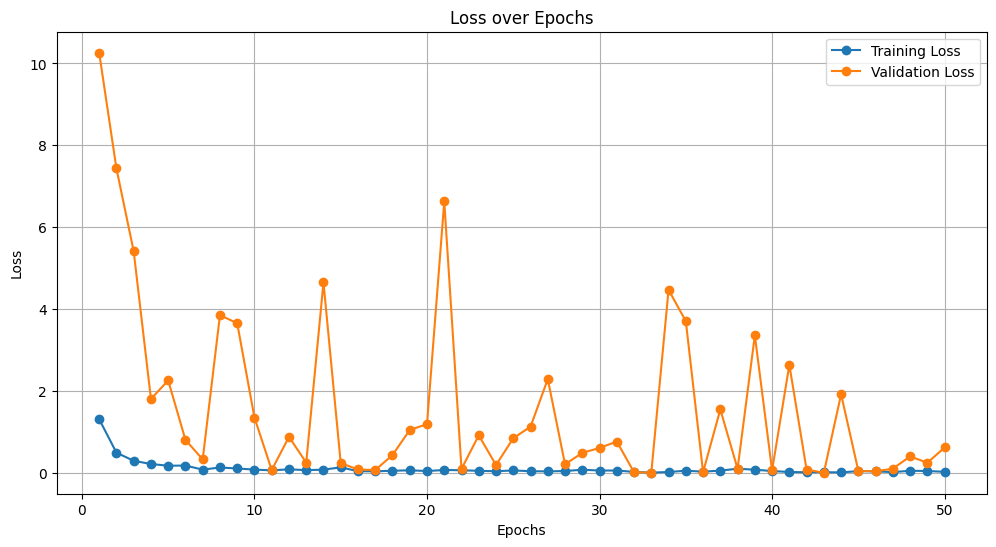

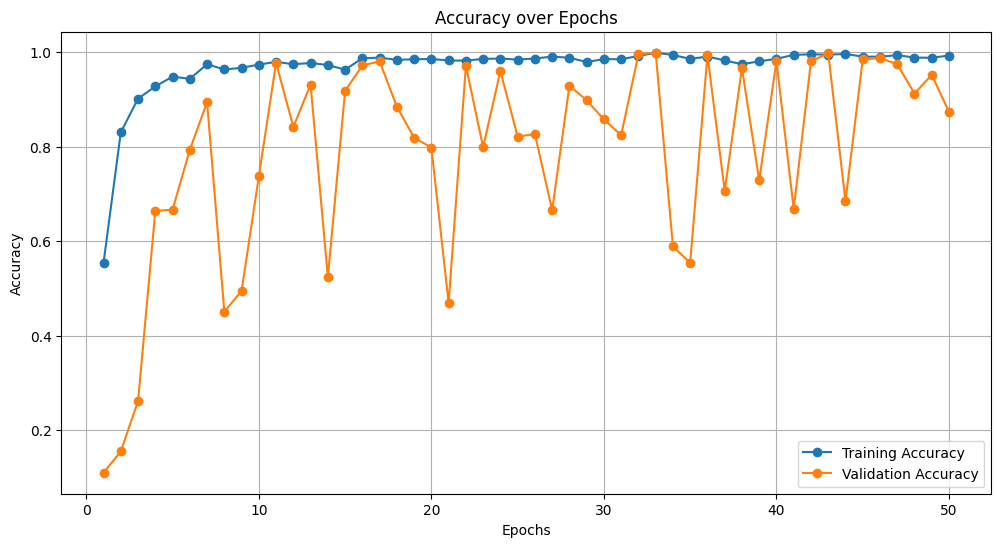

In [12]:
# Create the epoch range
epochs_range = range(1, epochs + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_loss_history, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss_history, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_acc_history, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc_history, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Load saved model and make prediction

In [13]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model(save_path)

# Optionally, print the model's summary to verify the structure
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,480,733 (28.54 MB)

 Trainable params: 2,493,449 (9.51 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 4,986,900 (19.02 MB)

In [14]:
results = model.evaluate(test)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - accuracy: 0.9988 - loss: 0.0019
Test Loss: 0.00312
Test Accuracy: 99.78%


In [15]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 206ms/step


In [16]:
# Step 2: Get true labels from the test dataset
y_true = []
for _, labels in test:  # Iterate over the test dataset
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class indices
y_true = np.array(y_true)

In [17]:
cm = confusion_matrix(y_true, pred)

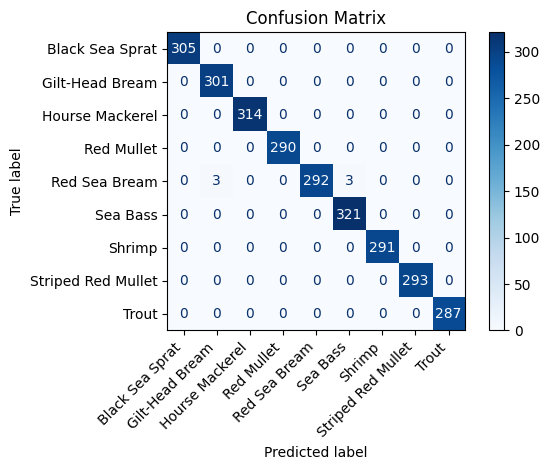

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = sorted(set(x_test['label'].values))  # Replace with actual class names if available
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate 45 degrees and align to the right
plt.title("Confusion Matrix")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [19]:
from sklearn.metrics import classification_report

pred_df = pd.DataFrame({
    'label': y_true,
    'pred': pred
})

print("Classification Report:")
print(classification_report(pred_df['label'], pred_df['pred'], target_names=class_names))

Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       305
   Gilt-Head Bream       0.99      1.00      1.00       301
   Hourse Mackerel       1.00      1.00      1.00       314
        Red Mullet       1.00      1.00      1.00       290
     Red Sea Bream       1.00      0.98      0.99       298
          Sea Bass       0.99      1.00      1.00       321
            Shrimp       1.00      1.00      1.00       291
Striped Red Mullet       1.00      1.00      1.00       293
             Trout       1.00      1.00      1.00       287

          accuracy                           1.00      2700
         macro avg       1.00      1.00      1.00      2700
      weighted avg       1.00      1.00      1.00      2700

